#  Итоговое задание

### В этой тетрадке мы будем анализировать информацию о породах собак

!WARNING в этой тетрадке несколько ячеек будут считаться очень долго ~30 минут, это веб-скрепинг и обучение нейронной сети. Для экономии времени проверяющего некоторые ячейки можно будет пропустить, и скачать уже подготовленные данные или веса нейронной сети.  

In [75]:
from tqdm.notebook import tqdm

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import requests
import random
import numpy as np
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

## Получим информацию о породах

Для начала подготовим данные. Нам понадобятся сайт https://lapkins.ru/dog/, с него, с помощью Selenium, мы возьмем список всех пород собак и информацию о кажой породе отдельно.

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

In [66]:
dogs_urls = {}

driver = webdriver.Firefox(executable_path="./geckodriver")

driver.get('https://lapkins.ru/dog/')
info = driver.find_element_by_class_name('pop-porodi-block')
info_items = info.find_elements_by_tag_name("a")
for i in info_items:
    link = i.get_attribute('href')
    breed = link.split('/')[4]
    dogs_urls[breed] = link
    
driver.close()

Создадим DataFrame с колонками-признаками. Нас интересует:
- название породы
- страна происхождения
- время происхождение
- средний вес
- средняя высота
- средняя продолжительность жизни. 

In [4]:
df = pd.DataFrame(columns=['Breed', 'Country', 'Origin', 'Weight', 'Height', 'Life expectancy'])

### Произведем *веб-скреппинг* с помощью *Selenium*.

In [5]:
russian_to_english_breed = {
    'Лабрадор-ретривер': 'labrador',
    'Боксер': 'boxer',
    'Сибирский хаски': 'husky',
    'Доберман': 'doberman',
    'Кавказская овчарка': 'ovcharka',
    'Питбуль': 'pitbull'
}

def getInfo(info_items):
    features = [None for i in range(6)]
    try:
        for item in info_items:
            if 'Название породы:' in item.text:
                breed = item.text[len('Название породы: '):]
                features[0] = russian_to_english_breed.get(breed, breed)
            if 'Страна происхождения:' in item.text:
                features[1] = item.text.split(' ')[2]
            if 'Время зарождения породы:' in item.text:
                features[2] = item.text[len('Время зарождения породы: '):]
            if 'Вес:' in item.text:
                weight = item.text.split(' ')[2]
                weight = weight.replace('~', ' ')
                weight = weight.split('-')[0]
                features[3] = weight
            if 'Рост (высота в холке):' in item.text:
                height = item.text.split(' ')[5]
                height = height.replace('~', ' ')
                height = height.split('-')[0]
                features[4] = height
            if 'Продолжительность жизни:' in item.text:
                age = item.text.split(' ')[2]
                age = age.replace('~', ' ')
                age = age.split('-')[0]
                features[5] = age
    except:
        pass
    return features

#### Ячейка считается очень долго, можно пропустить. Все данные уже лежат в файле dogs.csv.

In [ ]:
driver = webdriver.Firefox(executable_path="./geckodriver")

for i, url in enumerate(dogs_urls.values()): 
    driver.get(url)
    info = driver.find_element_by_class_name('info')
    info_items = info.find_elements_by_tag_name("li")
    df.loc[i] = getInfo(info_items)
    df.to_csv("dogs.csv", index=False)

driver.close()

### Получим DataFrame используя *Pandas* и удалим оттуда нерелевантные данные.  

In [76]:
df = pd.read_csv("dogs.csv")
df.head()

,Breed,Country,Origin,Weight,Height,Life expectancy
0,Австралийская овчарка (Аусси),США,NaN,25,51,13
1,Акита-ину,Япония,1964 год,–,64,10
2,Алабай (Среднеазиатская овчарка),СССР,XX век,минимум,минимум,от
3,Аляскинский кли-кай,США,1970-е годы,–,38,13
4,Аляскинский маламут,США,NaN,36,"63,5",13


In [77]:
weights = []
for i in df['Weight']:
    try:
        weights.append(float(i))
    except:
        weights.append(None)
        
df['Weight'] = weights

In [78]:
heights = []
for i in df['Height']:
    try:
        heights.append(float(i))
    except:
        heights.append(None)
        
df['Height'] = heights

In [79]:
expectancy = []
for i in df['Life expectancy']:
    try:
        expectancy.append(float(i))
    except:
        expectancy.append(None)
        
df['Life expectancy'] = expectancy

In [80]:
df['Height'] = df['Height'].fillna(-1)
df['Weight'] = df['Weight'].fillna(-1)
df['Life expectancy'] = df['Life expectancy'].fillna(-1)

df.head()

,Breed,Country,Origin,Weight,Height,Life expectancy
0,Австралийская овчарка (Аусси),США,NaN,25.0,51.0,13.0
1,Акита-ину,Япония,1964 год,-1.0,64.0,10.0
2,Алабай (Среднеазиатская овчарка),СССР,XX век,-1.0,-1.0,-1.0
3,Аляскинский кли-кай,США,1970-е годы,-1.0,38.0,13.0
4,Аляскинский маламут,США,NaN,36.0,-1.0,13.0


### *Визуализируем данные* с помощью *ggplot*

In [81]:
from plotnine import *

#### Продолжительность жизни

Посмотрим на среднюю продолжительность жизни собак. Видно, что большинсво собак живет от 10 до 14 лет. Причем, очень мало собак доживает до 15 лет :(

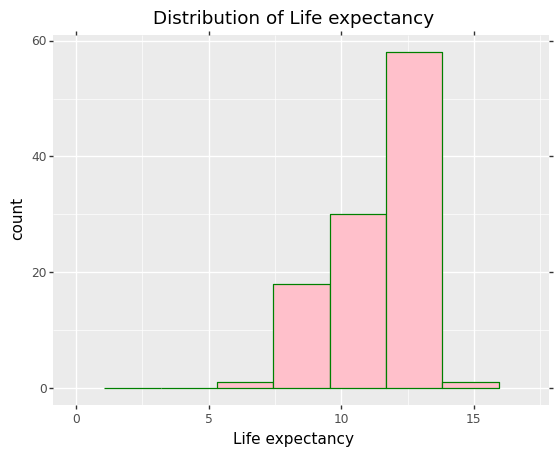

<ggplot: (8771152776659)>

In [84]:
(
    ggplot(df) +
    geom_histogram(
        aes(x = 'Life expectancy'),
        color = 'green',
        fill = 'pink'
    ) + 
    labs(
        title ='Distribution of Life expectancy'
    ) +
    scale_x_continuous(
        limits = (0, df['Life expectancy'].max()+3)
    )
)

#### Вес и высота собак

Посмотрим на взаимоотношение веса и высоты собаки. Видно, что высокие собаки весят больше, чем низкие, что логично. Заметим, что вес собак > 60 см значительно больше, чем вес низких собак.

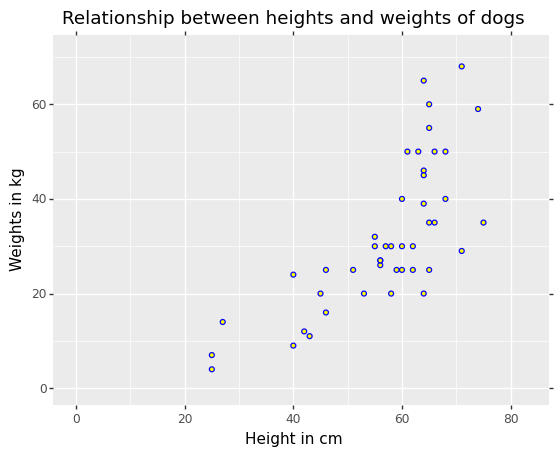

<ggplot: (8776247349291)>

In [41]:
(
    ggplot(df[df['Weight'] > -1].dropna(subset = ['Height'])) +
    geom_point(
        aes(x = 'Height',
            y = 'Weight'),
        fill = 'yellow', color = 'blue'
    ) +
    labs(
        title ='Relationship between heights and weights of dogs',
        x = 'Height in cm',
        y = 'Weights in kg',
    ) + 
    scale_x_continuous(
        limits = (0, df['Height'].max()+3)
    ) + 
    scale_y_continuous(
        limits = (0, df['Weight'].max()+3)
    )
)

#### Страна и высота собаки

Посмотрим на взаимоотношение стран и высоты собак. Тут мы видим, что в Германии находятся самые высокие породы собак, а, вот, в Великобритании почти все собаки маленькие. 

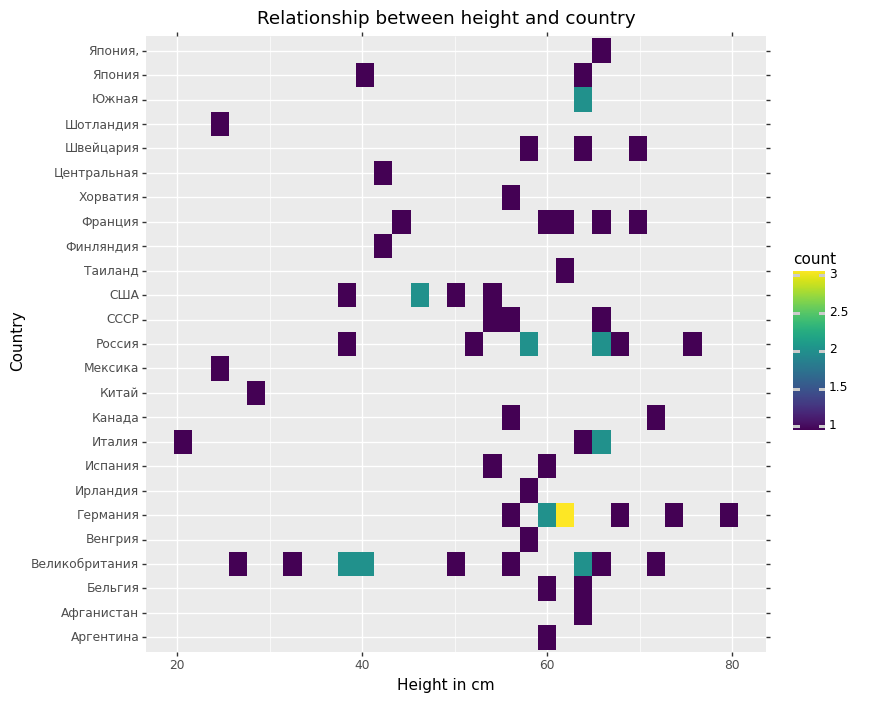

<ggplot: (-9223363260607547595)>

In [42]:
(
    ggplot(df[df['Height'] > -1].dropna(subset = ['Height'])) +
    geom_bin2d(
        aes(x = 'Height',
            y = 'Country')
    ) +
    labs(
        title ='Relationship between height and country',
        x = 'Height in cm',
        y = 'Country',
    ) +
    theme(figure_size = (8, 8))
)

### Используя *scipy* посмотрим на кореляцию признаков

- Видно, что, чем тяжалее собака, тем она выше;
- Можно сказать, что, страна происхождения породы влияет на высоту
- Вес собаки почти не связан со страной происхождения породы

In [62]:
import scipy
from scipy.stats import pearsonr

print('Pearson coef between Height and Weight: {}'.format(pearsonr(df['Height'], df['Weight'])[0]))
print('Pearson coef between Height and Life expectancy: {}'.format(pearsonr(df['Height'], df['Life expectancy'])[0]))
print('Pearson coef between Weight and Life expectancy: {}'.format(pearsonr(df['Life expectancy'], df['Weight'])[0]))

Pearson coef between Height and Weight: 0.604108275738374
Pearson coef between Height and Life expectancy: -0.2105477079525902
Pearson coef between Weight and Life expectancy: -0.029421718389228135


## Используя *REST API* сайта https://dog.ceo/dog-api/, получим картинки пород собак  

In [12]:
BREEDS = ['boxer', 'doberman', 'husky', 'labrador', 'ovcharka', 'pitbull']

os.mkdir('dogs')
os.mkdir('dogs/train')
os.mkdir('dogs/validation')

for breed in BREEDS:
    os.mkdir('dogs/train/{}'.format(breed))
    os.mkdir('dogs/validation/{}'.format(breed))

#### Проверим, что API работает

In [70]:
url = "https://dog.ceo/api/breed/labrador/images/random"
response = requests.request("GET", url)
print(response.json())

{'message': 'https://images.dog.ceo/breeds/labrador/n02099712_619.jpg', 'status': 'success'}


#### Загрузим изображения собак в созданные папки

In [71]:
url = "https://dog.ceo/api/breed/{}/images/random"

for breed in tqdm(BREEDS, 'Breeds'):
    for i in tqdm(range(170), breed + ' train', leave=False):
        response = requests.request("GET", url.format(breed)).json()
        if response['status'] == 'success':
            image_url = requests.get(response['message'])
            with open('./dogs/train/{}/{}.jpg'.format(breed, i), 'wb') as f:
                f.write(image_url.content)
                
    for i in tqdm(range(20), breed + ' validation', leave=False):
        response = requests.request("GET", url.format(breed)).json()
        if response['status'] == 'success':
            image_url = requests.get(response['message'])
            with open('./dogs/validation/{}/{}.jpg'.format(breed, i), 'wb') as f:
                f.write(image_url.content)

Проверим, что картинки созранились

<Figure size 432x288 with 0 Axes>

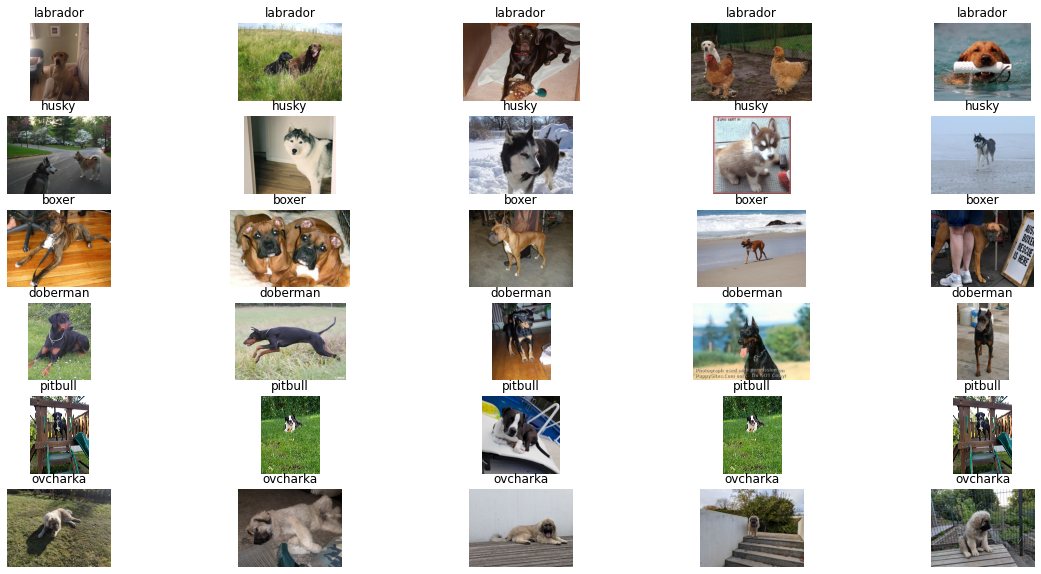

In [73]:
plt.figure()
f, axarr = plt.subplots(len(BREEDS), 5, figsize=(20, 10))

for i, breed in enumerate(BREEDS):
    for j in range(5):
        img = cv2.imread('./dogs/train/{}/{}.jpg'.format(breed, j))
        axarr[i, j].imshow(img[:,:,::-1])
        axarr[i, j].set_title(breed)
        axarr[i, j].axis('off')
        
plt.show()

# Простая нейронная сеть (с сайта)

Обучим нейронную сеть для классификации пород собак (основано на https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/)

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(255, 255, 3))

Using TensorFlow backend.


In [4]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

In [8]:
import keras
from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [9]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 10
val_batchsize = 2

train_generator = train_datagen.flow_from_directory(
        './dogs/train/',
        target_size=(255, 255),
        batch_size=train_batchsize,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        './dogs/validation/',
        target_size=(255, 255),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 1020 images belonging to 6 classes.
Found 120 images belonging to 6 classes.


### Train model

#### Обучение нейронной сети долгий процесс. Пропустите ячейку, веса обученной нейронной сети лежат в файле dogs_calss.h5.

In [93]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the model
model.save('dogs_calss.h5')

Epoch 1/5
102/102 [==============================] - 434s 4s/step - loss: 0.5754 - acc: 0.8118 - val_loss: 5.9605e-08 - val_acc: 0.8667
Epoch 2/5
102/102 [==============================] - 431s 4s/step - loss: 0.3903 - acc: 0.8667 - val_loss: 0.0000e+00 - val_acc: 0.8750
Epoch 3/5
102/102 [==============================] - 418s 4s/step - loss: 0.3576 - acc: 0.8745 - val_loss: 0.0000e+00 - val_acc: 0.9000
Epoch 4/5
102/102 [==============================] - 408s 4s/step - loss: 0.2390 - acc: 0.9235 - val_loss: 0.0000e+00 - val_acc: 0.8833
Epoch 5/5
102/102 [==============================] - 385s 4s/step - loss: 0.2463 - acc: 0.9314 - val_loss: 0.0000e+00 - val_acc: 0.9583


### Проверим как обучилась нейронная сеть

60/60 [==============================] - 34s 569ms/step


<Figure size 432x288 with 0 Axes>

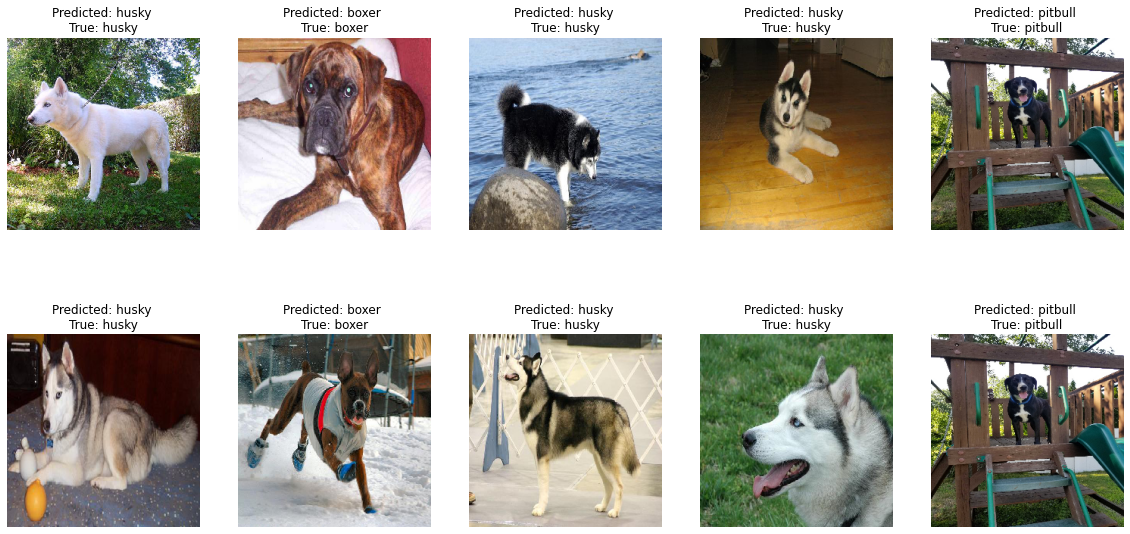

In [13]:
model = keras.models.load_model('dogs_calss.h5')

url = "https://dog.ceo/api/breed/{}/images/random"

predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
predicted_labels  = [BREEDS[x] for x in predicted_classes]

plt.figure()
f, axarr = plt.subplots(2, 5, figsize=(20, 10))

for col, i in enumerate(random.sample(range(len(validation_generator)), 5)):
    axarr[0, col].imshow(validation_generator[i][0][0])
    axarr[1, col].imshow(validation_generator[i][0][1])
    axarr[0, col].set_title('Predicted: {} \nTrue: {}'.format(predicted_labels[i*2], BREEDS[validation_generator.labels[i*2]]))
    axarr[1, col].set_title('Predicted: {} \nTrue: {}'.format(predicted_labels[i*2  + 1], BREEDS[validation_generator.labels[i*2 + 1]]))
    axarr[0, col].axis('off')
    axarr[1, col].axis('off')

# Объединим распознование картинок с DataFrame

In [70]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

def getInfoAboutADog(img_url):
    # download image
    image_url = requests.get(img_url)
    with open('./input.jpg', 'wb') as f:
        f.write(image_url.content)
    
    # predict breed (https://github.com/dabasajay/Image-Caption-Generator/blob/master/test.py)
    orig_image = load_img('./input.jpg', target_size=(255, 255))
    image = img_to_array(orig_image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    prediction = model.predict(image)
    # end of copypaste
    predicted_label = BREEDS[np.argmax(prediction[0])]
    
    # plot predictions
    plt.figure();
    f, axarr = plt.subplots(1, 1, figsize=(5, 5));
    axarr.imshow(orig_image);
    axarr.set_title(predicted_label);
    axarr.axis('off');
    
    # print info
    print('Порода:                  ' + predicted_label)
    print('Страна:                  ' + df[df['Breed'] == predicted_label]['Country'].values[0])
    print('Происхождение:           ' + df[df['Breed'] == predicted_label]['Origin'].values[0])
    print('Вес:                     ' + df[df['Breed'] == predicted_label]['Weight'].values[0])
    print('Высота:                  ' + df[df['Breed'] == predicted_label]['Height'].values[0])
    print('Продолжительность жизни: ' + df[df['Breed'] == predicted_label]['Life expectancy'].values[0])
    
    plt.show()

Порода:                  husky
Страна:                  Россия
Происхождение:           1966 год
Вес:                     20
Высота:                  53
Продолжительность жизни: 12


<Figure size 432x288 with 0 Axes>

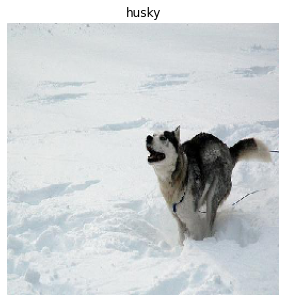

In [71]:
getInfoAboutADog('https://images.dog.ceo/breeds/husky/n02110185_11773.jpg')

Порода:                  doberman
Страна:                  Германия
Происхождение:           1890 год
Вес:                     40
Высота:                  68
Продолжительность жизни: 10


<Figure size 432x288 with 0 Axes>

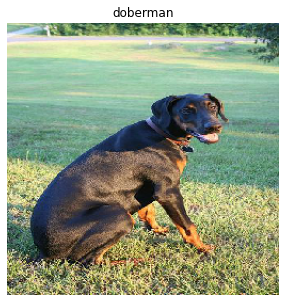

In [74]:
getInfoAboutADog('https://images.dog.ceo/breeds/doberman/n02107142_5284.jpg')

Порода:                  doberman
Страна:                  Германия
Происхождение:           1890 год
Вес:                     40
Высота:                  68
Продолжительность жизни: 10


<Figure size 432x288 with 0 Axes>

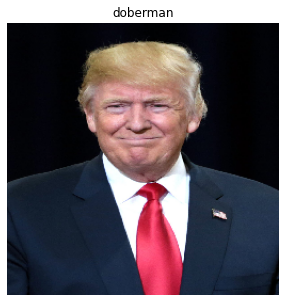

In [73]:
getInfoAboutADog('https://www.investors.com/wp-content/uploads/2018/10/President_Trump_2.jpg')

## Запустим проект на Streamlit

Запустите команду и перейдите по появившейся ссылке.

In [ ]:
!pip install streamlit
!streamlit run dogsapp.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.12:8501

Using TensorFlow backend.
/home/tema/Programs/anaconda/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tema/Programs/anaconda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/tema/Programs/anaconda/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 8 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/tema/Programs/anaconda/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing 

# Вывод

#### Была проделана большая работа. Были применены технологии:
- обработка данных с pandas
- визуализация данных
- scipy
- веб-скрепинг с помощью Selenium
- загрузка картинок с REST API и объединение их с другим датасетом (нетривиальное использование)
- ggplot2
- keras для нейросети
- целостная работа
- более 120 строчек осмысленного кода
- проект на Streamlit

### Спасибо за внимание!